In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q transformers==4.37.2
!pip install "pandas<2.0.0"

In [3]:
import os
import pickle
import itertools


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from tensorflow import keras
from glob import glob
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model


In [4]:
%matplotlib inline

In [5]:
from transformers import BertTokenizer, TFBertModel

from transformers import logging
logging.set_verbosity_error()

In [6]:
# brendanho123
# data_path = 'drive/My Drive/Colab Notebooks/W266/Final Project/data'

# bho1
data_path = 'drive/My Drive/Colab Notebooks/Final Project/data'

# bholly597
# data_path = 'drive/My Drive/Final Project/data'

In [7]:
checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizer.from_pretrained(checkpoint)
bert_model = TFBertModel.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [8]:
unpickled_data = {}

keys_to_unpickle = [
    'train_data',
    'test_data',
    'val_data',
]


for key in keys_to_unpickle:
    filename = f'{data_path}/cleaned_data/{key}.pkl'
    with open(filename, 'rb') as file:
        unpickled_data[key] = pickle.load(file)


train_data = unpickled_data['train_data']
test_data = unpickled_data['test_data']
val_data = unpickled_data['val_data']


In [9]:
MAX_SEQUENCE_LENGTH = 128                 # set max_length of the input sequence

# num_train_examples = 2000
# num_val_examples = 200


num_train_examples = 10000
num_val_examples = 1000


# num_train_examples = 50000
# num_val_examples = 5000

# num_train_examples = train_data.shape[0]
# num_val_examples = test_data.shape[0]


In [10]:
x_train_file_path = f'{data_path}/tokens/x_train_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_val_file_path = f'{data_path}/tokens/x_val_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
x_test_file_path = f'{data_path}/tokens/x_test_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

# Get train data
if os.path.exists(x_train_file_path):
  x_train = pickle.load(open(x_train_file_path, 'rb'))
else:
  x_train = bert_tokenizer(list(train_data['text'])[:num_train_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')


  with open(x_train_file_path, 'wb') as f:
    pickle.dump(x_train, f)

# Get val data
if os.path.exists(x_val_file_path):
  x_val = pickle.load(open(x_val_file_path, 'rb'))
else:
  x_val = bert_tokenizer(list(val_data['text'])[:num_val_examples],
              max_length=MAX_SEQUENCE_LENGTH,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

  with open(x_val_file_path, 'wb') as f:
    pickle.dump(x_val, f)

# Get test data
if os.path.exists(x_test_file_path):
  x_test = pickle.load(open(x_test_file_path, 'rb'))
else:
  x_test = bert_tokenizer(list(test_data['text'])[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')

  with open(x_test_file_path, 'wb') as f:
    pickle.dump(x_test, f)


y_train = train_data['Overall_score'][:num_train_examples]
y_val = val_data['Overall_score'][:num_val_examples]
y_test = test_data['Overall_score'][:num_val_examples]


In [11]:
# Experiment 2 UIDs specifics here

anime_features_train = train_data['anime_uid'][:num_train_examples]
anime_features_val = val_data['anime_uid'][:num_val_examples]
anime_features_test = test_data['anime_uid'][:num_val_examples]

user_features_train = train_data['profile_uid'][:num_train_examples]
user_features_val = val_data['profile_uid'][:num_val_examples]
user_features_test = test_data['profile_uid'][:num_val_examples]

In [12]:

train_synopsis_file_path = f'{data_path}/tokens/train_synopsis_tokens_{num_train_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
val_synopsis_file_path = f'{data_path}/tokens/val_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'
test_synopsis_file_path = f'{data_path}/tokens/test_synopsis_tokens_{num_val_examples}_{MAX_SEQUENCE_LENGTH}.pkl'

if os.path.exists(train_synopsis_file_path):
  bert_train_synopsis = pickle.load(open(train_synopsis_file_path, 'rb'))
else:
  train_synopsis = train_data['synopsis'].astype(str).tolist()
  bert_train_synopsis = bert_tokenizer(train_synopsis[:num_train_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(train_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_train_synopsis, f)

if os.path.exists(val_synopsis_file_path):
  bert_val_synopsis = pickle.load(open(val_synopsis_file_path, 'rb'))
else:
  val_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_val_synopsis = bert_tokenizer(val_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(val_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_val_synopsis, f)

if os.path.exists(test_synopsis_file_path):
  bert_test_synopsis = pickle.load(open(test_synopsis_file_path, 'rb'))
else:
  test_synopsis = test_data['synopsis'].astype(str).tolist()
  bert_test_synopsis = bert_tokenizer(test_synopsis[:num_val_examples],
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  with open(test_synopsis_file_path, 'wb') as f:
    pickle.dump(bert_test_synopsis, f)

### Model

In [13]:
# Experiment 2

num_animes = 8113
num_users = 47885

In [14]:
def create_two_tower_model(
    bert_model,
    train_layers=True,
    layers=[70, 50, 20, 10],
    dropout=0.3,
    optimizer_type='adam',
    learning_rate=0.00005,
    loss='mean_absolute_error',
    embedding_size=10, ################### Experiment 2
):

    if not train_layers:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Train all layers of the BERT model
        bert_model.trainable = True

    # Anime Embeddings

    anime_features = tf.keras.layers.Input(shape=(1,), name='anime_features_input')
    anime_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_animes, input_length=num_train_examples, name='anime_embedding')(anime_features)
    anime_vec = tf.keras.layers.Flatten(name='anime_flatten')(anime_features_embed)

    anime_model = keras.Model(inputs=anime_features, outputs=anime_vec)

    # User Embeddings
    user_features = tf.keras.layers.Input(shape=(1,), name='user_features_input')
    user_features_embed = tf.keras.layers.Embedding(output_dim=embedding_size, input_dim=num_users, input_length=num_train_examples, name='user_embedding')(user_features)
    user_vec = tf.keras.layers.Flatten(name='user_flatten')(user_features_embed)

    user_model = keras.Model(inputs=user_features, outputs=user_vec)


    merged = tf.keras.layers.Dot(name = 'dot_product', normalize = True, axes = 2)([anime_features_embed, user_features_embed])

    dense_layers = []
    dropout_layers = []
    for i, num_layers in enumerate(layers):
      if i == 0:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(merged)
      else:
        dense = tf.keras.layers.Dense(num_layers, name=f'dense_{i + 1}', activation='relu')(dropout_layers[-1])
      dense_layers.append(dense)

      if i != len(layers) - 1:
        dropout_layer = tf.keras.layers.Dropout(dropout, name=f'dropout_{i + 1}')(dense_layers[-1])
        dropout_layers.append(dropout_layer)

    result = tf.keras.layers.Dense(1, name='result', activation="relu") (dense_layers[-1])

    if optimizer_type == 'adam':
      optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_type == 'adagrad':
      optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_type == 'adamax':
      optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

    model = keras.Model(inputs=[anime_features, user_features], outputs=result)
    model.compile(optimizer=optimizer, loss=loss)

    return model, anime_model, user_model

### Parameters

In [15]:
parameters = {
    'train_layers': True,
    'layers': [70, 50, 20, 10],
    'dropout': 0.2,
    'optimizer_type': 'adam',
    'learning_rate': 0.001,
    'loss': 'mean_absolute_error',
}

In [16]:
bert_model = TFBertModel.from_pretrained(checkpoint)
two_tower_bert_model, anime_model, user_model = create_two_tower_model(bert_model, **parameters)

In [17]:
# two_tower_bert_model.summary()

In [18]:
# keras.utils.plot_model(two_tower_bert_model, show_shapes=True, dpi=90)

## Evaluate on Test Set

In [19]:

batch_size = 16
epochs = 50

callback  = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
two_tower_bert_model_history = two_tower_bert_model.fit(
    [
        anime_features_train,  ###### Experiment 2
        user_features_train,  ###### Experiment 2
    ],
    y_train.astype(float),
    validation_data=(
        [
            anime_features_val,  ###### Experiment 2
            user_features_val,  ###### Experiment 2
        ], y_val.astype(float)),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[callback]
)

Epoch 1/50
625/625 [==============================] - 11s 7ms/step - loss: 2.6929 - val_loss: 1.9092
Epoch 2/50
625/625 [==============================] - 4s 6ms/step - loss: 2.0199 - val_loss: 1.8420
Epoch 3/50
625/625 [==============================] - 4s 6ms/step - loss: 1.9213 - val_loss: 1.9027
Epoch 4/50
625/625 [==============================] - 3s 5ms/step - loss: 1.8667 - val_loss: 1.8687
Epoch 5/50
625/625 [==============================] - 3s 5ms/step - loss: 1.8061 - val_loss: 1.9008
Epoch 6/50
625/625 [==============================] - 4s 6ms/step - loss: 1.7599 - val_loss: 1.8769
Epoch 7/50
625/625 [==============================] - 4s 6ms/step - loss: 1.7190 - val_loss: 1.9117
Epoch 8/50
625/625 [==============================] - 3s 5ms/step - loss: 1.6849 - val_loss: 1.8935
Epoch 9/50
625/625 [==============================] - 3s 5ms/step - loss: 1.6597 - val_loss: 1.9908
Epoch 10/50
625/625 [==============================] - 4s 7ms/step - loss: 1.6294 - val_loss: 1.944

In [ ]:
print("Evaluate")
test_dataset = [
    anime_features_test,  ###### Experiment 2
    user_features_test,  ###### Experiment 2
]
result = two_tower_bert_model.evaluate(test_dataset, y_test)


Evaluate
32/32 [==============================] - 0s 3ms/step - loss: 1.9606


In [ ]:
result

1.9606064558029175

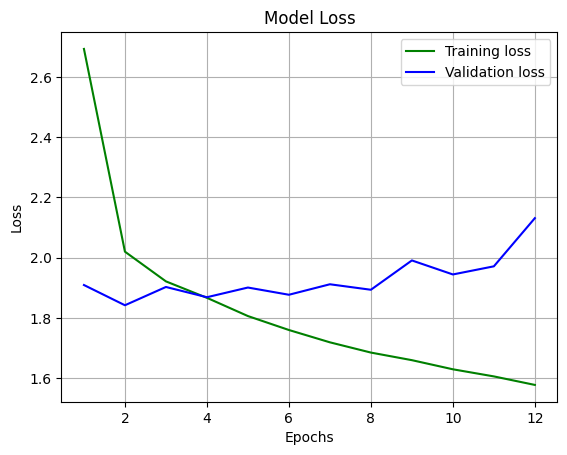

In [20]:
train_loss = two_tower_bert_model_history.history['loss']
val_loss = two_tower_bert_model_history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Movie Embeddings

In [21]:
import pandas as pd
all_data = pd.concat([train_data[:num_train_examples], val_data[:num_val_examples], test_data[:num_val_examples]])
animes = pd.read_csv(f'{data_path}/raw_data/animes_final.csv')

In [22]:
all_anime_ids = all_data['anime_uid'].unique()
all_present_anime_ids = animes[animes['uid'].isin(all_anime_ids)].sort_values(by='popularity')['uid']

In [23]:
unique_anime_ids = all_present_anime_ids[:2000]

anime_id_dict = {id: i for i, id in enumerate(unique_anime_ids)}

print(f'The length of the unique anime ids is {len(unique_anime_ids)}')

The length of the unique anime ids is 2000


In [24]:
emb_list = []
for anime_id in unique_anime_ids:
  anime_embeddings = anime_model.predict(np.array([anime_id]))
  val = list(anime_embeddings.reshape(1,-1))[0]
  emb_list.insert(anime_id, val)

1/1 [==============================] - 0s 17ms/step


In [ ]:
print(len(emb_list))

2000


In [ ]:
emb_list[5]

array([-0.02875841,  0.04845823,  0.10333069,  0.02118396,  0.07400819,
       -0.11702804, -0.02247956,  0.1263672 ,  0.12158161, -0.07431285],
      dtype=float32)

In [ ]:
def tsne_plot(
    embeddings,
    size=len(emb_list),
    figsize=(20, 20)
):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(embeddings[:size])

    # Store x and y values from T-SNE
    x, y = [], []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=figsize)
    # Plot x,y values

    labels = list(range(0,size))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],xy=(x[i], y[i]),xytext=(5, 2),textcoords='offset points',ha='right',va='bottom')

    plt.show()
    return new_values

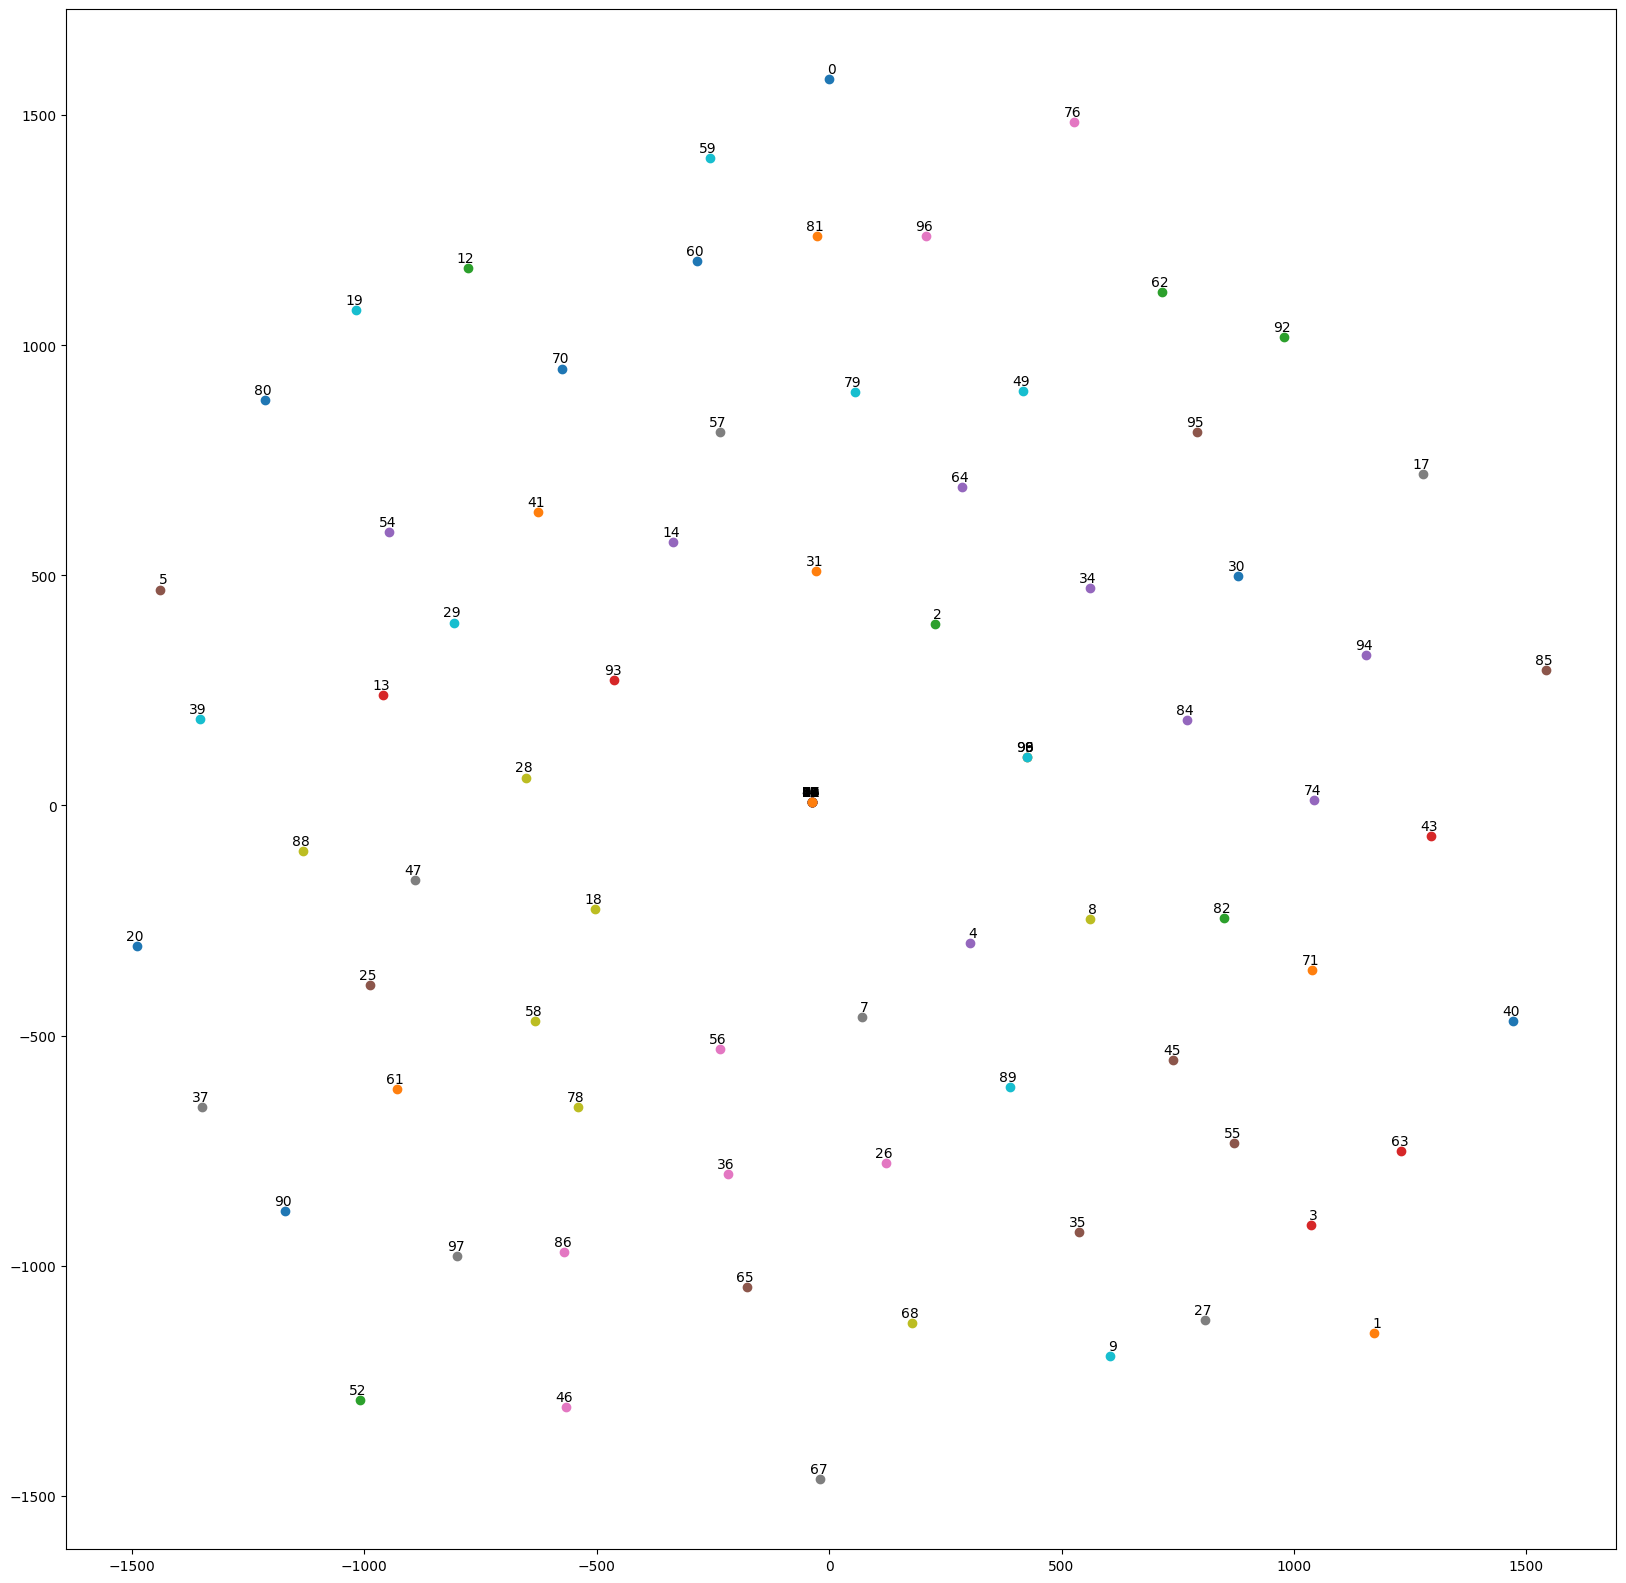

In [ ]:
pca_values = tsne_plot(np.array(emb_list), 100)

### KNN

In [25]:
n_neighbors = 10

In [26]:
# Fit a KNN Clasiffier

clf = KNeighborsClassifier(n_neighbors=n_neighbors+1)
clf.fit(emb_list, unique_anime_ids)

KNeighborsClassifier(n_neighbors=11)

In [27]:
def anime_recommendations(user_embedding, n_neibhors=n_neighbors):
    _, idxs = clf.kneighbors(user_embedding.reshape(1, -1),  n_neighbors=n_neighbors)
    idxs = idxs.reshape(10,1)

    df_indices = pd.DataFrame(idxs, columns = ['anime_uid'])

    return df_indices.merge(animes.rename(columns={'uid': 'anime_uid'}), on='anime_uid', how='inner')['title']

In [28]:
selected_test_data = test_data.iloc[:num_val_examples]
user_embeddings = user_model.predict(selected_test_data['profile_uid'])

32/32 [==============================] - 0s 1ms/step


In [ ]:
user_idx = 45

In [ ]:
for i in range(10):
  print(f'User {i} Recommendations:')
  print(anime_recommendations(user_embeddings[i].reshape(1,-1)[0]))

User 0 Recommendations:
0                       Keiraku no Houteishiki Level-C
1      Captain Tsubasa: Saikyou no Teki! Holland Youth
2          Dragon Ball Z: Saiya-jin Zetsumetsu Keikaku
3    Mobile Suit Zeta Gundam: A New Translation II ...
4                                      Dotto Koni-chan
5                                        Gakuen Heaven
6                                 Tetsuwan Atom (1980)
7                                Super Doll Licca-chan
8       Detective Conan Movie 04: Captured in Her Eyes
9                                  Hokuto no Ken Movie
Name: title, dtype: object
User 1 Recommendations:
0                                            Koihime
1                            Gakuen Tokusou Hikaruon
2                     Keiraku no Houteishiki Level-C
3                              Taiyou no Kiba Dagram
4                                     Daa! Daa! Daa!
5                         Soujuu Senshi Psychic Wars
6                                     Chirin no Suzu
7   

### Coverage

In [29]:
unique_profile_ids = selected_test_data['profile_uid'].unique()
print(len(unique_profile_ids))

948


In [30]:
unique_recommendations = set()
unique_recommendation_pairs = set()
total_recommendations = 0
user_recommendations = 0
for i in range(len(user_embeddings)):
  recommendations = anime_recommendations(user_embeddings[i])
  unique_recommendations.update(recommendations.values)
  unique_recommendation_pairs.update([(selected_test_data.iloc[i]['profile_uid'], rec) for rec in recommendations.values])
  total_recommendations += len(recommendations)
  if len(recommendations) > 0:
    user_recommendations += 1



print(f'Unique Recommendations: {len(unique_recommendations)}')
print(f'Unique Recommendation Pairs: {len(unique_recommendation_pairs)}')
print(f'Total Recommendations: {total_recommendations}')
print(f'User Recommendations: {user_recommendations}')

Unique Recommendations: 1144
Unique Recommendation Pairs: 8605
Total Recommendations: 9082
User Recommendations: 1000


In [31]:

print(f'Item Coverage: {len(unique_recommendations) / len(unique_anime_ids)}')
print(f'User Coverage: {user_recommendations / num_val_examples}')
print(f'Total Coverage: {len(unique_recommendation_pairs) / (len(unique_anime_ids) * len(unique_profile_ids))}')

Item Coverage: 0.572
User Coverage: 1.0
Total Coverage: 0.004538502109704641


### Precision and Recall at K

In [32]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, true_r, est in predictions:
        user_est_true[uid].append((est[0], true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [33]:
selected_test_datat = test_data.iloc[:num_val_examples]

In [34]:
test_input = selected_test_datat[['anime_uid', 'profile_uid']].values
input_array_1 = test_input[:, 0]
input_array_2 = test_input[:, 1]

model_predictions = two_tower_bert_model.predict([input_array_1, input_array_2])

32/32 [==============================] - 0s 4ms/step


In [36]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: [0.10495781]
Recall@10: [0.10232068]
F1@10: [0.10362246]


In [37]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=7.5)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: [0.03270042]
Recall@10: [0.03164557]
F1@10: [0.03216435]


In [38]:
k = 10
precisions, recalls = precision_recall_at_k(zip(selected_test_datat['profile_uid'], y_test, model_predictions), k=k, threshold=8)

precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
recall_at_k = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Precision@{k}: {precision_at_k}')
print(f'Recall@{k}: {recall_at_k}')
print(f'F1@{k}: {2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k)}')

Precision@10: [0.00738397]
Recall@10: [0.00738397]
F1@10: [0.00738397]
